In [1]:
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd

transform = transforms.Compose([
    transforms.Resize((50,50)), 
    transforms.ToTensor() 
])

data = ImageFolder(root="./add_data", transform=transform)
data2 = ImageFolder(root="./data_test", transform=transform)

c:\Users\mathn\.conda\envs\Torch_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
data_loader = DataLoader(data, batch_size=10, shuffle=True)    
test_loader = DataLoader(data2, batch_size=8, shuffle=True)

In [3]:
images, labels = next(iter(data_loader))
print(images.shape, labels.shape) # shape : [개수, 채널 수, 높이, 너비]

torch.Size([10, 3, 50, 50]) torch.Size([10])


In [4]:
class Mob_Dog(nn.Module): # 클래스 생성
    def __init__(self):
        super(Mob_Dog, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) # 두번 컨볼루션 연산 해주기
        
        
        
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
# 모델 객체 생성, 옵티마이저 생성
model = Mob_Dog()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

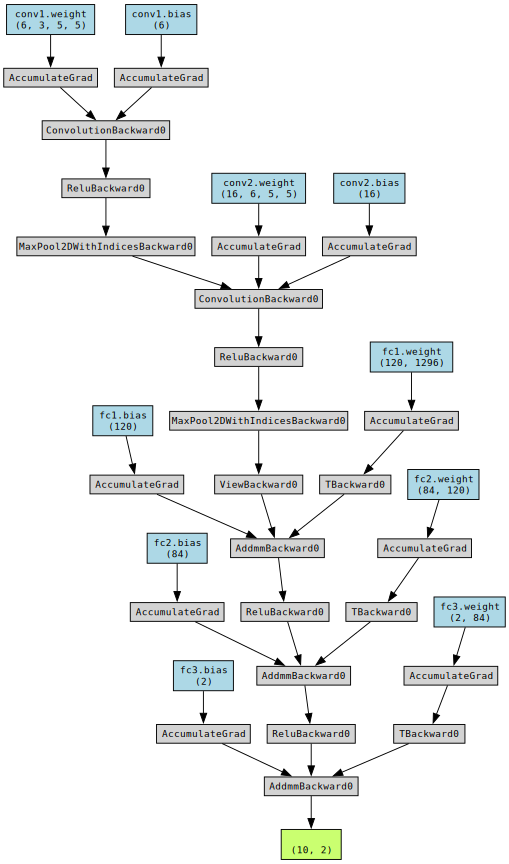

In [7]:
from torchviz import make_dot

x=torch.randn(10,3,50,50)# 들어가는 차원

make_dot(model(x),params=dict(model.named_parameters()))

In [ ]:
def get_accuracy(loader, model):
    total=0
    correct=0
    for data in loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # dim=1을 주어 최종 값 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
from tqdm import tqdm # 프로그레스 바 생성
from torch.optim.lr_scheduler import ReduceLROnPlateau # 스케줄러 생성 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, verbose=True)

loss_list=[]
tas_list=[]
tes_list=[]
max=0
for epoch in range(100): # 10회 반복 
    running_loss = 0.0 # 1 epoch당 누적 로스값 
    #==================================================================================
    pbar = tqdm(enumerate(data_loader), total=len(data_loader)) 
    for i, data in pbar: # pbar가 데이터 로더 역할 수행
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # 로스 누적 
        if i % 10 == 9:
            pbar.set_description(f'Epoch [{epoch + 1}/{100}], 횟수 [{i + 1}/{len(data_loader)}], Loss: {running_loss / 10:.4f}')
            loss_list.append(running_loss)
            running_loss = 0.0
    #==================================================================================   
    # 모델 평가

    with torch.no_grad():
        train_accuracy = get_accuracy(data_loader, model)
        test_accuracy = get_accuracy(test_loader, model)
    print(f'{epoch} Epoch 종료 후 train_score : {(100 * train_accuracy)}')
    print(f'{epoch} Epoch 종료 후 test_score : {(100 * test_accuracy)}')
    tas_list.append(train_accuracy)
    tes_list.append(test_accuracy)
    if max < test_accuracy:
        max = test_accuracy
        torch.save(model, 'first_model.pth')
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early Stopping at : {epoch} Epoch")
        break

c:\Users\mathn\.conda\envs\Torch_PY38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [1/100], 횟수 [40/43], Loss: 0.6314: 100%|██████████| 43/43 [00:00<00:00, 45.36it/s]


0 Epoch 종료 후 train_score : 52.3696682464455
0 Epoch 종료 후 test_score : 56.52173913043478


Epoch [2/100], 횟수 [40/43], Loss: 0.4915: 100%|██████████| 43/43 [00:00<00:00, 48.49it/s]


1 Epoch 종료 후 train_score : 82.46445497630332
1 Epoch 종료 후 test_score : 80.43478260869566


Epoch [3/100], 횟수 [40/43], Loss: 0.3995: 100%|██████████| 43/43 [00:00<00:00, 49.17it/s]


2 Epoch 종료 후 train_score : 84.36018957345972
2 Epoch 종료 후 test_score : 81.52173913043478


Epoch [4/100], 횟수 [40/43], Loss: 0.4424: 100%|██████████| 43/43 [00:00<00:00, 51.14it/s]


3 Epoch 종료 후 train_score : 82.93838862559242
3 Epoch 종료 후 test_score : 81.52173913043478


Epoch [5/100], 횟수 [40/43], Loss: 0.4295: 100%|██████████| 43/43 [00:01<00:00, 39.10it/s]


4 Epoch 종료 후 train_score : 83.41232227488152
4 Epoch 종료 후 test_score : 81.52173913043478


Epoch [6/100], 횟수 [40/43], Loss: 0.4503: 100%|██████████| 43/43 [00:00<00:00, 47.11it/s]


5 Epoch 종료 후 train_score : 78.67298578199052
5 Epoch 종료 후 test_score : 71.73913043478261


Epoch [7/100], 횟수 [40/43], Loss: 0.3696: 100%|██████████| 43/43 [00:01<00:00, 37.00it/s]


6 Epoch 종료 후 train_score : 82.46445497630332
6 Epoch 종료 후 test_score : 75.0


Epoch [8/100], 횟수 [40/43], Loss: 0.3408: 100%|██████████| 43/43 [00:00<00:00, 50.41it/s]


7 Epoch 종료 후 train_score : 78.90995260663507
7 Epoch 종료 후 test_score : 71.73913043478261


Epoch [9/100], 횟수 [40/43], Loss: 0.3306: 100%|██████████| 43/43 [00:00<00:00, 52.38it/s]


8 Epoch 종료 후 train_score : 85.78199052132702
8 Epoch 종료 후 test_score : 88.04347826086956


Epoch [10/100], 횟수 [40/43], Loss: 0.2682: 100%|██████████| 43/43 [00:00<00:00, 48.62it/s]


9 Epoch 종료 후 train_score : 87.44075829383885
9 Epoch 종료 후 test_score : 84.78260869565217


Epoch [11/100], 횟수 [40/43], Loss: 0.2343: 100%|██████████| 43/43 [00:00<00:00, 51.80it/s]


10 Epoch 종료 후 train_score : 86.7298578199052
10 Epoch 종료 후 test_score : 88.04347826086956


Epoch [12/100], 횟수 [40/43], Loss: 0.3651: 100%|██████████| 43/43 [00:01<00:00, 40.98it/s]


11 Epoch 종료 후 train_score : 88.15165876777252
11 Epoch 종료 후 test_score : 90.21739130434783


Epoch [13/100], 횟수 [40/43], Loss: 0.3812: 100%|██████████| 43/43 [00:00<00:00, 45.65it/s]


12 Epoch 종료 후 train_score : 88.38862559241706
12 Epoch 종료 후 test_score : 90.21739130434783


Epoch [14/100], 횟수 [40/43], Loss: 0.3002: 100%|██████████| 43/43 [00:00<00:00, 44.51it/s]


13 Epoch 종료 후 train_score : 89.81042654028435
13 Epoch 종료 후 test_score : 90.21739130434783


Epoch [15/100], 횟수 [40/43], Loss: 0.2695: 100%|██████████| 43/43 [00:00<00:00, 49.74it/s]


14 Epoch 종료 후 train_score : 88.38862559241706
14 Epoch 종료 후 test_score : 85.86956521739131


Epoch [16/100], 횟수 [40/43], Loss: 0.2921: 100%|██████████| 43/43 [00:00<00:00, 49.44it/s]


15 Epoch 종료 후 train_score : 91.23222748815166
15 Epoch 종료 후 test_score : 89.13043478260869


Epoch [17/100], 횟수 [40/43], Loss: 0.2503: 100%|██████████| 43/43 [00:00<00:00, 45.25it/s]


16 Epoch 종료 후 train_score : 91.9431279620853
16 Epoch 종료 후 test_score : 88.04347826086956


Epoch [18/100], 횟수 [40/43], Loss: 0.2679: 100%|██████████| 43/43 [00:00<00:00, 48.51it/s]


17 Epoch 종료 후 train_score : 90.52132701421802
17 Epoch 종료 후 test_score : 89.13043478260869


Epoch [19/100], 횟수 [40/43], Loss: 0.2738: 100%|██████████| 43/43 [00:00<00:00, 49.49it/s]


18 Epoch 종료 후 train_score : 90.52132701421802
18 Epoch 종료 후 test_score : 84.78260869565217


Epoch [20/100], 횟수 [40/43], Loss: 0.2661: 100%|██████████| 43/43 [00:00<00:00, 43.08it/s]


19 Epoch 종료 후 train_score : 92.18009478672985
19 Epoch 종료 후 test_score : 89.13043478260869


Epoch [21/100], 횟수 [40/43], Loss: 0.2421: 100%|██████████| 43/43 [00:00<00:00, 46.17it/s]


20 Epoch 종료 후 train_score : 88.86255924170617
20 Epoch 종료 후 test_score : 85.86956521739131


Epoch [22/100], 횟수 [40/43], Loss: 0.1984: 100%|██████████| 43/43 [00:00<00:00, 44.76it/s]


21 Epoch 종료 후 train_score : 88.62559241706161
21 Epoch 종료 후 test_score : 81.52173913043478


Epoch [23/100], 횟수 [40/43], Loss: 0.5069: 100%|██████████| 43/43 [00:00<00:00, 51.57it/s]


22 Epoch 종료 후 train_score : 84.59715639810426
22 Epoch 종료 후 test_score : 83.69565217391305


Epoch [24/100], 횟수 [40/43], Loss: 0.4958: 100%|██████████| 43/43 [00:00<00:00, 49.66it/s]


23 Epoch 종료 후 train_score : 79.38388625592417
23 Epoch 종료 후 test_score : 69.56521739130434


Epoch [25/100], 횟수 [40/43], Loss: 0.3267: 100%|██████████| 43/43 [00:00<00:00, 52.17it/s]


24 Epoch 종료 후 train_score : 86.25592417061611
24 Epoch 종료 후 test_score : 84.78260869565217


Epoch [26/100], 횟수 [40/43], Loss: 0.2496: 100%|██████████| 43/43 [00:00<00:00, 52.57it/s]


25 Epoch 종료 후 train_score : 90.99526066350711
25 Epoch 종료 후 test_score : 88.04347826086956


Epoch [27/100], 횟수 [40/43], Loss: 0.2453: 100%|██████████| 43/43 [00:00<00:00, 48.27it/s]


26 Epoch 종료 후 train_score : 88.15165876777252
26 Epoch 종료 후 test_score : 86.95652173913044


Epoch [28/100], 횟수 [40/43], Loss: 0.1872: 100%|██████████| 43/43 [00:00<00:00, 48.74it/s]


27 Epoch 종료 후 train_score : 90.99526066350711
27 Epoch 종료 후 test_score : 84.78260869565217


Epoch [29/100], 횟수 [40/43], Loss: 0.1904: 100%|██████████| 43/43 [00:00<00:00, 48.68it/s]


28 Epoch 종료 후 train_score : 93.36492890995261
28 Epoch 종료 후 test_score : 84.78260869565217


Epoch [30/100], 횟수 [40/43], Loss: 0.2319: 100%|██████████| 43/43 [00:00<00:00, 45.28it/s]


29 Epoch 종료 후 train_score : 95.02369668246445
29 Epoch 종료 후 test_score : 84.78260869565217


Epoch [31/100], 횟수 [40/43], Loss: 0.1079: 100%|██████████| 43/43 [00:00<00:00, 49.51it/s]


30 Epoch 종료 후 train_score : 92.89099526066352
30 Epoch 종료 후 test_score : 85.86956521739131


Epoch [32/100], 횟수 [40/43], Loss: 0.2230: 100%|██████████| 43/43 [00:01<00:00, 39.39it/s]


31 Epoch 종료 후 train_score : 96.44549763033176
31 Epoch 종료 후 test_score : 88.04347826086956


Epoch [33/100], 횟수 [40/43], Loss: 0.1459: 100%|██████████| 43/43 [00:00<00:00, 47.26it/s]


32 Epoch 종료 후 train_score : 85.54502369668246
32 Epoch 종료 후 test_score : 77.17391304347827


Epoch [34/100], 횟수 [40/43], Loss: 0.2483: 100%|██████████| 43/43 [00:00<00:00, 44.85it/s]


33 Epoch 종료 후 train_score : 95.02369668246445
33 Epoch 종료 후 test_score : 84.78260869565217


Epoch [35/100], 횟수 [40/43], Loss: 0.1398: 100%|██████████| 43/43 [00:01<00:00, 39.90it/s]


34 Epoch 종료 후 train_score : 96.44549763033176
34 Epoch 종료 후 test_score : 85.86956521739131


Epoch [36/100], 횟수 [40/43], Loss: 0.1449: 100%|██████████| 43/43 [00:00<00:00, 46.16it/s]


35 Epoch 종료 후 train_score : 94.7867298578199
35 Epoch 종료 후 test_score : 82.6086956521739


Epoch [37/100], 횟수 [40/43], Loss: 0.1725: 100%|██████████| 43/43 [00:00<00:00, 44.32it/s]


36 Epoch 종료 후 train_score : 97.39336492890996
36 Epoch 종료 후 test_score : 85.86956521739131


Epoch [38/100], 횟수 [40/43], Loss: 0.1165: 100%|██████████| 43/43 [00:01<00:00, 42.86it/s]


37 Epoch 종료 후 train_score : 95.73459715639811
37 Epoch 종료 후 test_score : 85.86956521739131


Epoch [39/100], 횟수 [40/43], Loss: 0.1318: 100%|██████████| 43/43 [00:00<00:00, 44.70it/s]


38 Epoch 종료 후 train_score : 92.41706161137441
38 Epoch 종료 후 test_score : 84.78260869565217


Epoch [40/100], 횟수 [40/43], Loss: 0.1045: 100%|██████████| 43/43 [00:01<00:00, 42.08it/s]


39 Epoch 종료 후 train_score : 98.10426540284361
39 Epoch 종료 후 test_score : 84.78260869565217


Epoch [41/100], 횟수 [40/43], Loss: 0.0821: 100%|██████████| 43/43 [00:00<00:00, 43.56it/s]


40 Epoch 종료 후 train_score : 97.86729857819904
40 Epoch 종료 후 test_score : 84.78260869565217
Early Stopping at : 40 Epoch


(0.981042654028436, 0.9021739130434783)


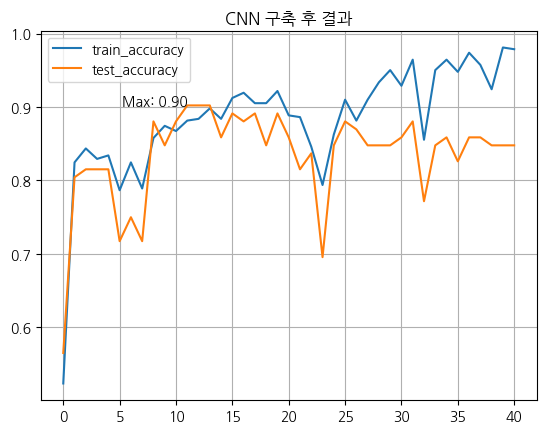

In [ ]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

# 그래프 그리기
plt.plot(tas_list, label="train_accuracy")
plt.plot(tes_list, label="test_accuracy")
plt.grid(True)
plt.legend()

max_value = (np.max(tas_list), np.max(tes_list))
print(max_value)
max_index = tas_list.index(max_value[1]) if max_value[1] in tas_list else tes_list.index(max_value[1])
max_x = max_index
max_y = max_value[1]
plt.text(max_x, max_y, f'Max: {max_y:.2f}', ha='right')
plt.title("CNN 구축 후 결과")
plt.show()